In [1]:
!hostname

n96.clstr


This Jupyter notebook is used to explore the relationship between Precipitation and ROS 
- 
- Compares Precip Accumulation to ROS hours 

In [1]:
import xarray as xr
import os
import glob
import geopandas as gpd
import pandas as pd
import numpy as np
import re
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import seaborn as sns
from scipy.stats import linregress
from scipy.stats import pearsonr, spearmanr


Loading in the data 

In [5]:
path='/import/c1/DYNDOWN/phutton5/ROS/FNSB/FNSB_netcdf_files/ROS_Precip/'
pattern=f'ROS_P*.nc'
file_list = sorted(glob.glob(os.path.join(path, pattern)))
data = xr.open_mfdataset(file_list, combine='by_coords',engine='netcdf4')

start_year = '1950-1951'
data = data.sel(season=data.season >= start_year)
seasons=data['season']
average_ROS_tally=np.nanmean(data['ros_counts'],axis=0)

rain_ros_avg_hourly=data['rain_ros_avg']
rain_ros_sum=data['rain_ros_sum']

In [6]:
shapefile_path = "/center1/DYNDOWN/phutton5/ROS/boundaries/Alaska_Borough_and_Census_Area_Boundaries.shp"
borough_boundaries = gpd.read_file(shapefile_path)
borough_boundaries = borough_boundaries.set_crs(epsg=3338)
borough_boundaries = borough_boundaries.to_crs(epsg=4326)
FNSB_boundary = borough_boundaries[borough_boundaries['CommunityN'] == 'Fairbanks North Star Borough']
FNSB_geom = FNSB_boundary.geometry.iloc[0] 
FNSB_coords = []
FNSB_coords.extend(list(FNSB_geom.exterior.coords))
FNSB_coords = np.array(FNSB_coords)  
FNSB_coords = pd.DataFrame({
    "lon": FNSB_coords[:, 0],
    "lat": FNSB_coords[:, 1]
})

Fairbanks_lat=(64.84)
Fairbanks_lon=(-147.72)
lat=data['XLAT']
lon=data['XLONG']

Loading in the shapefiles for boundary and Fairbanks 

In [7]:
ros_hourly_totals_climatology = []
for i in range(len(data['ros_tally'].season)):
    val = data['ros_tally'].isel(season=i).sum().compute().item()
    ros_hourly_totals_climatology.append(val)

In [8]:
n_pixels_per_season = []

for i in range(len(data['ros_tally'].season)):
    # Get 2D field for the season
    ros_this_season = data['ros_tally'].isel(season=i)
    
    # Create a boolean mask of where ROS occurred (value > 0)
    grid_with_ros = ros_this_season > 0
    
    # Count how many grid cells had ROS
    n_pixels = grid_with_ros.sum().compute().item()
    n_pixels_per_season.append(n_pixels)


ros_hours_normalized = [total / n if n > 0 else np.nan 
                        for total, n in zip(ros_hourly_totals_climatology, n_pixels_per_season)]

In [ ]:
#Finding the average TOTAL Rain for each winter season 
rain_sum_fnsb=[]
for i in range(len(data['rain_sum'].season)):
    avg=data['rain_sum'].isel(season=i).mean().compute().item()
    #avg = (avg - 273.15) * 9/5 + 32
    rain_sum_fnsb.append(avg)
print(rain_sum_fnsb)

[0.011356600560247898, 0.02237807959318161, 0.020322280004620552, 0.01274876482784748, 0.03306262567639351, 0.0047749909572303295, 0.07649489492177963, 0.04012715071439743, 0.0044593820348382, 0.018588632345199585, 0.024269621819257736, 0.07754270732402802, 0.20528900623321533, 0.025813743472099304, 0.07243597507476807, 0.013078109361231327, 0.0199687872081995, 0.1815306693315506, 0.020694615319371223, 0.03461587429046631, 0.08063007146120071, 0.025618962943553925, 0.033112533390522, 0.005293040536344051, 0.012338658794760704, 0.035052042454481125, 0.08290060609579086, 0.013391224667429924, 0.029104024171829224, 0.10849703103303909, 0.03419908508658409, 0.04440384358167648, 0.02091294154524803, 0.021119657903909683, 0.04191945865750313, 0.058176688849925995, 0.06179330125451088, 0.011041778139770031, 0.05764307454228401, 0.0272569190710783, 0.06463170051574707, 0.013642125762999058, 0.033878885209560394, 0.042278941720724106, 0.01357797160744667, 0.014977913349866867, 0.010122573003172

In [10]:
#finding the average Rain for each winter season ONLY when ROS hours occured
rain_sum_ROS_fnsb=[]
for i in range(len(data['rain_ros_sum'].season)):
    avg=data['rain_ros_sum'].isel(season=i).mean().compute().item()
    rain_sum_ROS_fnsb.append(avg)
print(rain_sum_ROS_fnsb)

[0.003915431443601847, 0.00977920088917017, 0.004474786575883627, 0.006847456097602844, 0.011572318151593208, 0.0009232447482645512, 0.053750310093164444, 0.019271915778517723, 0.0007550655282102525, 0.0053793140687048435, 0.005389997735619545, 0.055722665041685104, 0.1502196043729782, 0.010897052474319935, 0.04176374152302742, 0.007910512387752533, 0.011869720183312893, 0.1262948215007782, 0.014978252351284027, 0.011579577811062336, 0.061059318482875824, 0.01539904996752739, 0.023829570040106773, 0.0004937267513014376, 0.0024832729250192642, 0.026259634643793106, 0.045900244265794754, 0.001219859579578042, 0.013457637280225754, 0.06747682392597198, 0.0075705102644860744, 0.020542452111840248, 0.00399052444845438, 0.00445165392011404, 0.016060050576925278, 0.027295920997858047, 0.03993642330169678, 0.003407127456739545, 0.04481247812509537, 0.007913381792604923, 0.049761246889829636, 0.003425653325393796, 0.007569297216832638, 0.015790963545441628, 0.002098025055602193, 0.0016896126326

In [11]:
print('Average Rain Nov-Mar', np.mean(rain_sum_fnsb))
print('When ROS occurs average Rain',np.mean(rain_sum_ROS_fnsb))

Average Rain Nov-Mar 0.0416534850940209
When ROS occurs average Rain 0.023099933230794803


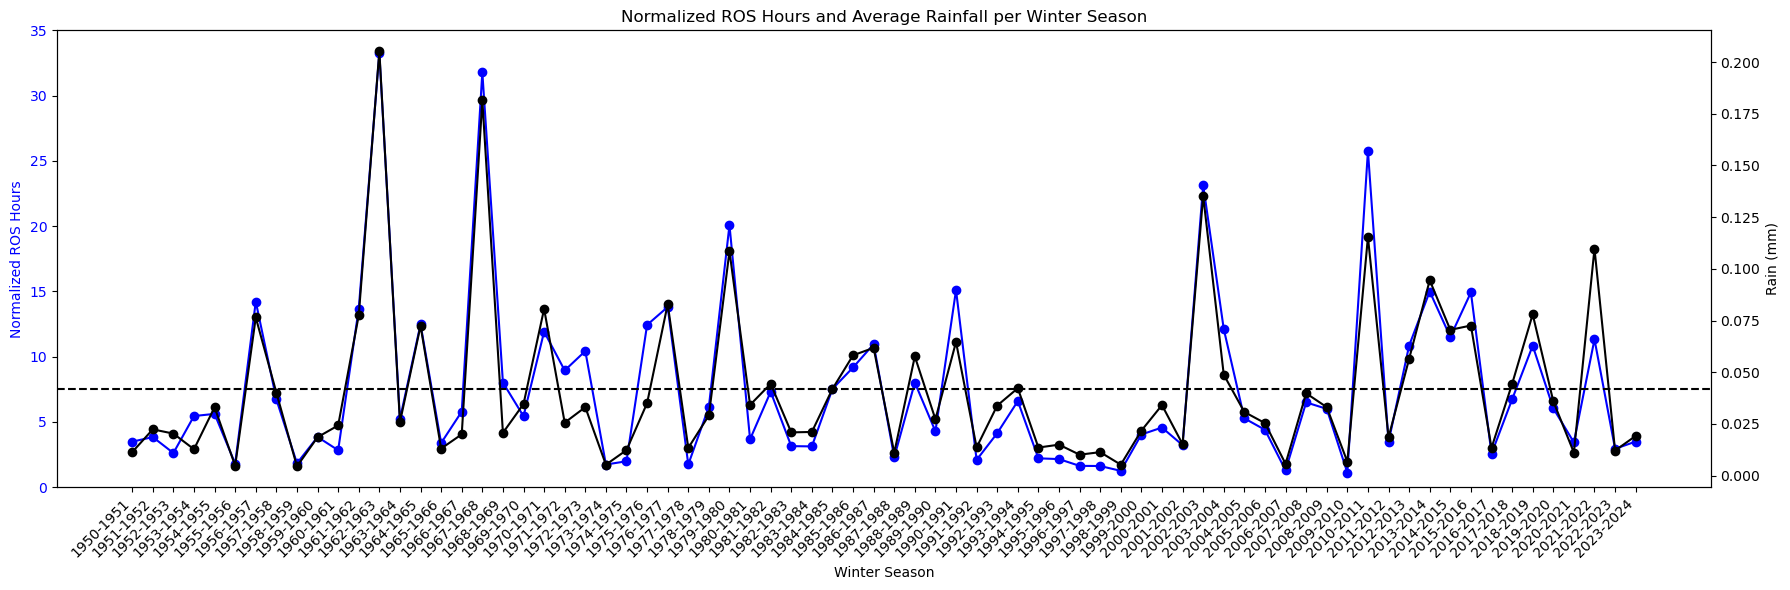

In [12]:
fig, ax1 = plt.subplots(figsize=(18, 6))
#ros_hours_normalized
ax1.plot(seasons, ros_hours_normalized, marker='o', linestyle='-', color='blue', label='ROS Hours')
ax1.set_xlabel('Winter Season')
ax1.set_ylabel('Normalized ROS Hours', color='blue')
ax1.set_ylim(0,35)
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(seasons, rain_sum_fnsb, marker='o', linestyle='-', color='black', label='')
plt.axhline(np.mean(rain_sum_fnsb), color='black', linestyle='--') 
ax2.set_ylabel('Rain (mm)', color='black')
ax2.tick_params(axis='y', labelcolor='black')

plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
#plt.xticks(ticks=range(0, total_seasons, 2), labels=df['season'].iloc[::2], rotation=45)
plt.title('Normalized ROS Hours and Average Rainfall per Winter Season')
fig.tight_layout()
plt.show()

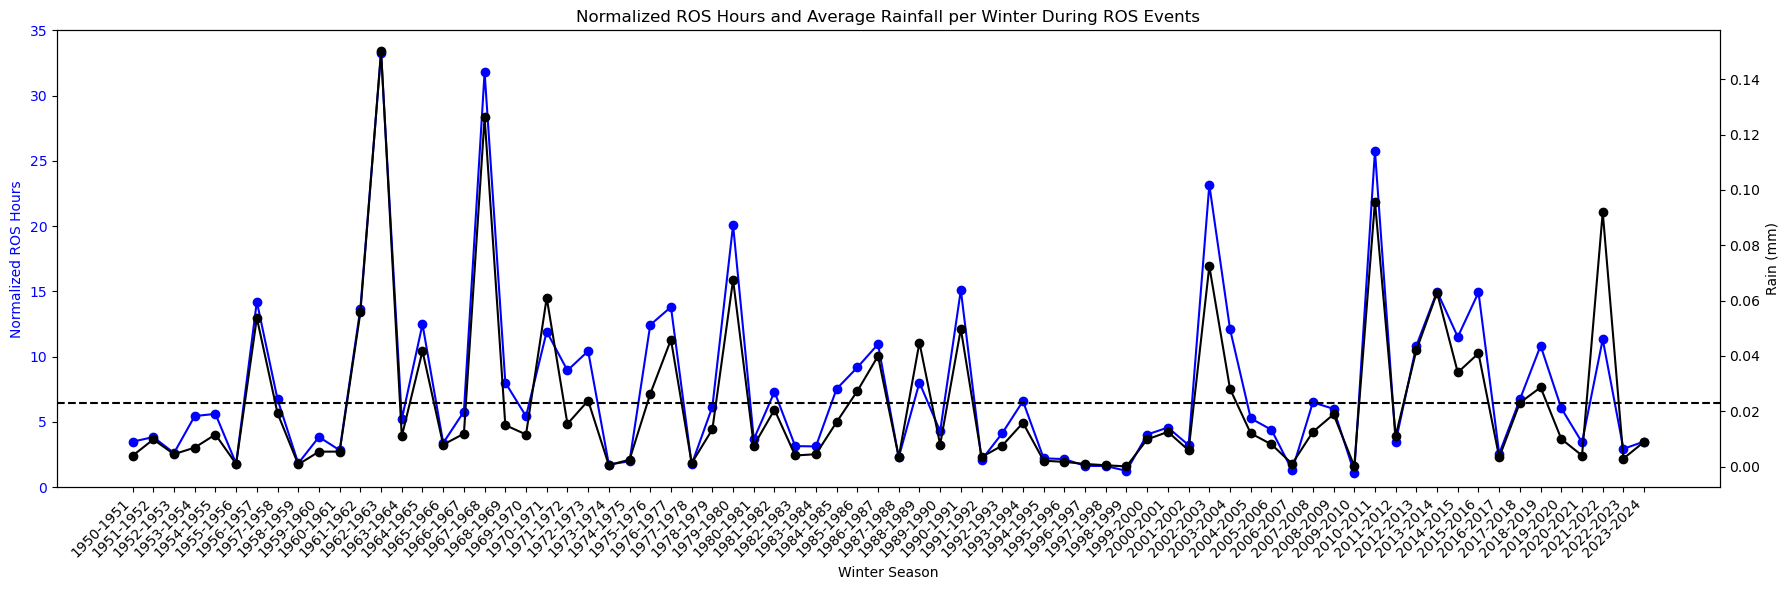

In [13]:
fig, ax1 = plt.subplots(figsize=(18, 6))
#ros_hours_normalized
ax1.plot(seasons, ros_hours_normalized, marker='o', linestyle='-', color='blue', label='ROS Hours')
ax1.set_xlabel('Winter Season')
ax1.set_ylabel('Normalized ROS Hours', color='blue')
ax1.set_ylim(0,35)
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(seasons, rain_sum_ROS_fnsb, marker='o', linestyle='-', color='black', label='')
plt.axhline(np.mean(rain_sum_ROS_fnsb), color='black', linestyle='--') 
ax2.set_ylabel('Rain (mm)', color='black')
ax2.tick_params(axis='y', labelcolor='black')

plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
#plt.xticks(ticks=range(0, total_seasons, 2), labels=df['season'].iloc[::2], rotation=45)
plt.title('Normalized ROS Hours and Average Rainfall per Winter During ROS Events')
fig.tight_layout()
plt.show()

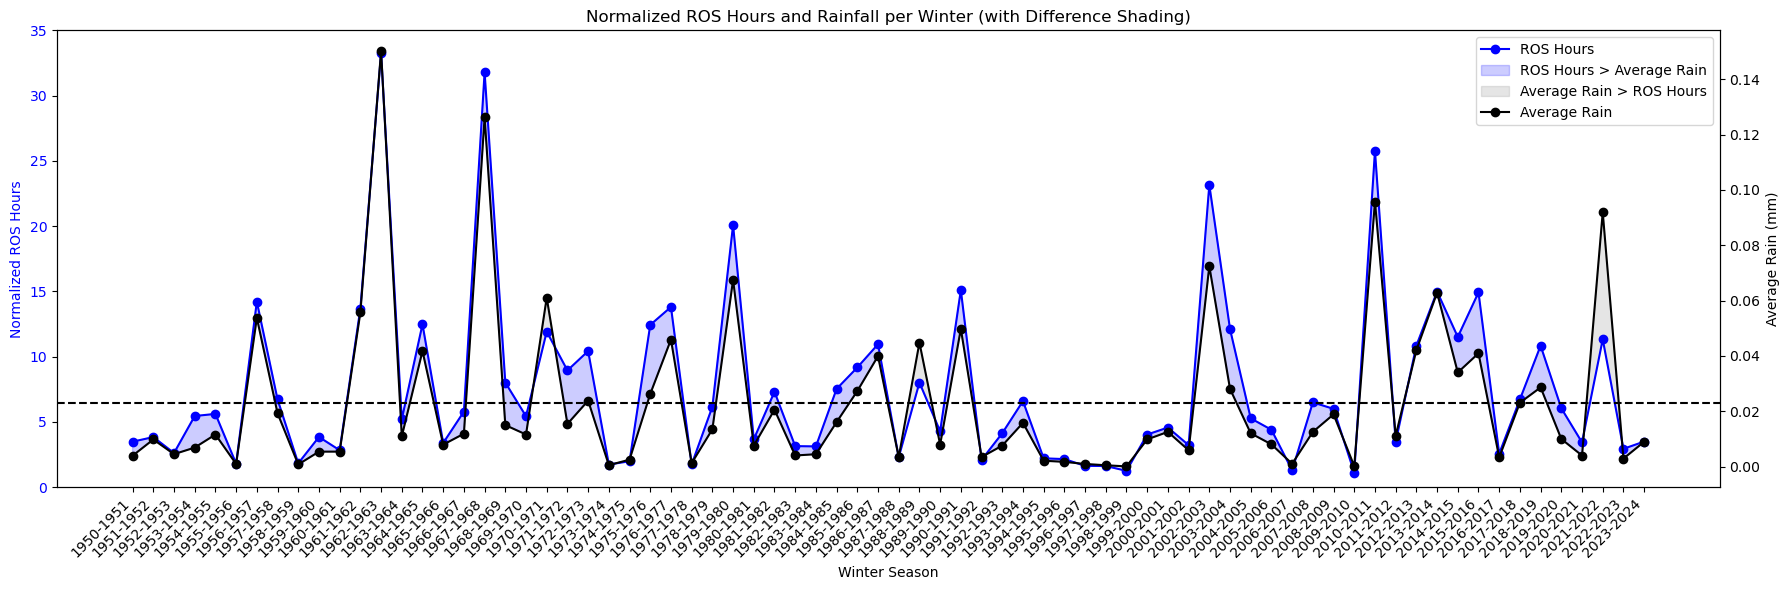

In [14]:
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import numpy as np

fig, ax1 = plt.subplots(figsize=(18, 6))

# Plot ROS hours on ax1
line1, = ax1.plot(seasons, ros_hours_normalized, marker='o', linestyle='-', color='blue', label='ROS Hours')
ax1.set_xlabel('Winter Season')
ax1.set_ylabel('Normalized ROS Hours', color='blue')
ax1.set_ylim(0, 35)
ax1.tick_params(axis='y', labelcolor='blue')

# Create second y-axis
ax2 = ax1.twinx()
line2, = ax2.plot(seasons, rain_sum_ROS_fnsb, marker='o', linestyle='-', color='black', label='Average Rain')
ax2.axhline(np.mean(rain_sum_ROS_fnsb), color='black', linestyle='--') 
ax2.set_ylabel('Average Rain (mm)', color='black')
ax2.tick_params(axis='y', labelcolor='black')

trans1 = ax1.transData
trans2 = ax2.transData
inv_trans2 = ax2.transData.inverted()

rain_as_ax1_coords = [trans1.inverted().transform(trans2.transform((0, y)))[1] for y in rain_sum_ROS_fnsb]
ax1.fill_between(seasons, ros_hours_normalized, rain_as_ax1_coords,
                 where=(np.array(ros_hours_normalized) > np.array(rain_as_ax1_coords)),
                 interpolate=True, color='blue', alpha=0.2, label='ROS Hours > Average Rain')

ax1.fill_between(seasons, ros_hours_normalized, rain_as_ax1_coords,
                 where=(np.array(ros_hours_normalized) <= np.array(rain_as_ax1_coords)),
                 interpolate=True, color='gray', alpha=0.2, label='Average Rain > ROS Hours')
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
plt.title('Normalized ROS Hours and Rainfall per Winter (with Difference Shading)')
fig.tight_layout()
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

#fig.legend(loc='upper right', bbox_to_anchor=(1, 1))
plt.show()


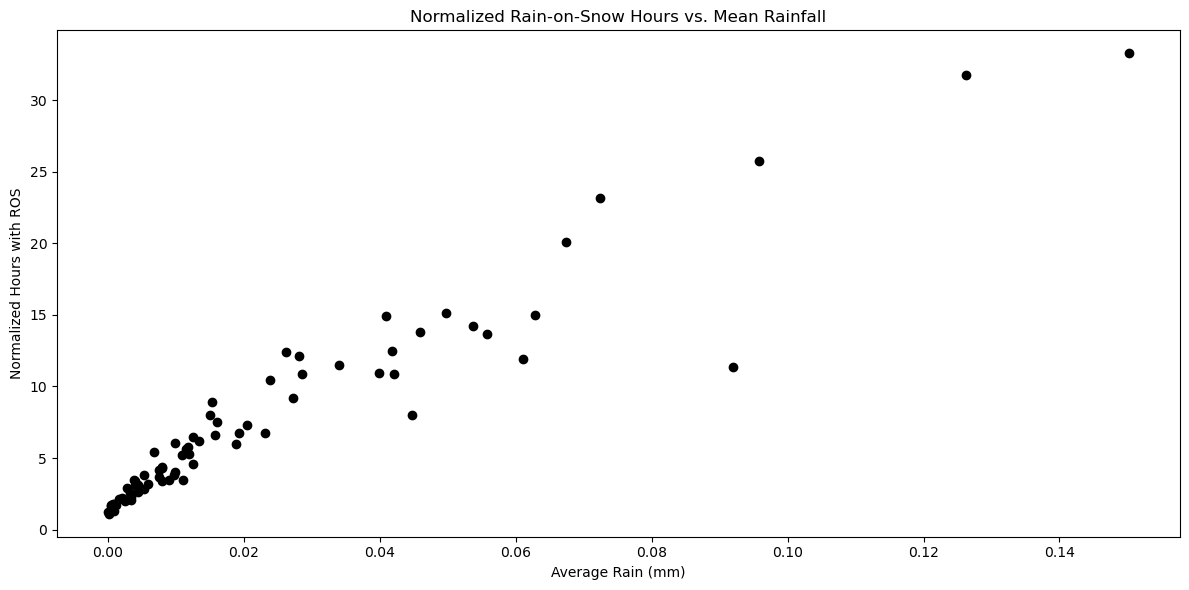

Pearson r: 0.950 (pvalue=3.772e-38)
R2: 0.9026306954462922


In [15]:
plt.figure(figsize=(12, 6))
plt.plot(rain_sum_ROS_fnsb, ros_hours_normalized, marker='o', linestyle='', color='black')
plt.title('Normalized Rain-on-Snow Hours vs. Mean Rainfall')
plt.xlabel('Average Rain (mm)')
plt.ylabel('Normalized Hours with ROS')
plt.tight_layout()
plt.show()
pearson_r, p_pearson = pearsonr(rain_sum_ROS_fnsb, ros_hours_normalized)
print(f"Pearson r: {pearson_r:.3f} (pvalue={p_pearson:.3e})")
r_squared_from_r = pearson_r ** 2 
print(f"R2: {r_squared_from_r}")

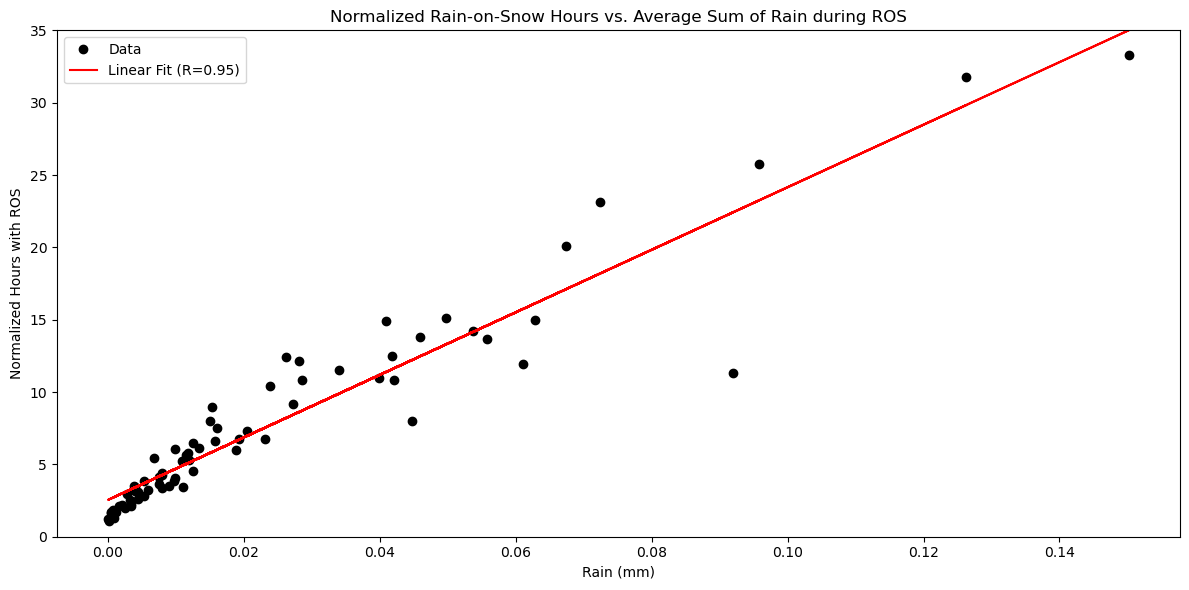

In [16]:
slope, intercept, r_value, p_value, std_err = linregress(rain_sum_ROS_fnsb, ros_hours_normalized)
x = np.array(rain_sum_ROS_fnsb)
y_fit = slope * x + intercept

plt.figure(figsize=(12, 6))
plt.plot(rain_sum_ROS_fnsb, ros_hours_normalized, marker='o', linestyle='', color='black', label='Data')
plt.plot(x, y_fit, color='red', label=f'Linear Fit (R={r_value:.2f})')

plt.title('Normalized Rain-on-Snow Hours vs. Average Sum of Rain during ROS')
plt.xlabel('Rain (mm)')
plt.ylabel('Normalized Hours with ROS')
plt.legend()
plt.ylim(0,35)

plt.tight_layout()
plt.gcf().patch.set_alpha(0.0)
plt.show()

There is a strong and statistically significant relationship between rain amount and ROS hours.
-

- 

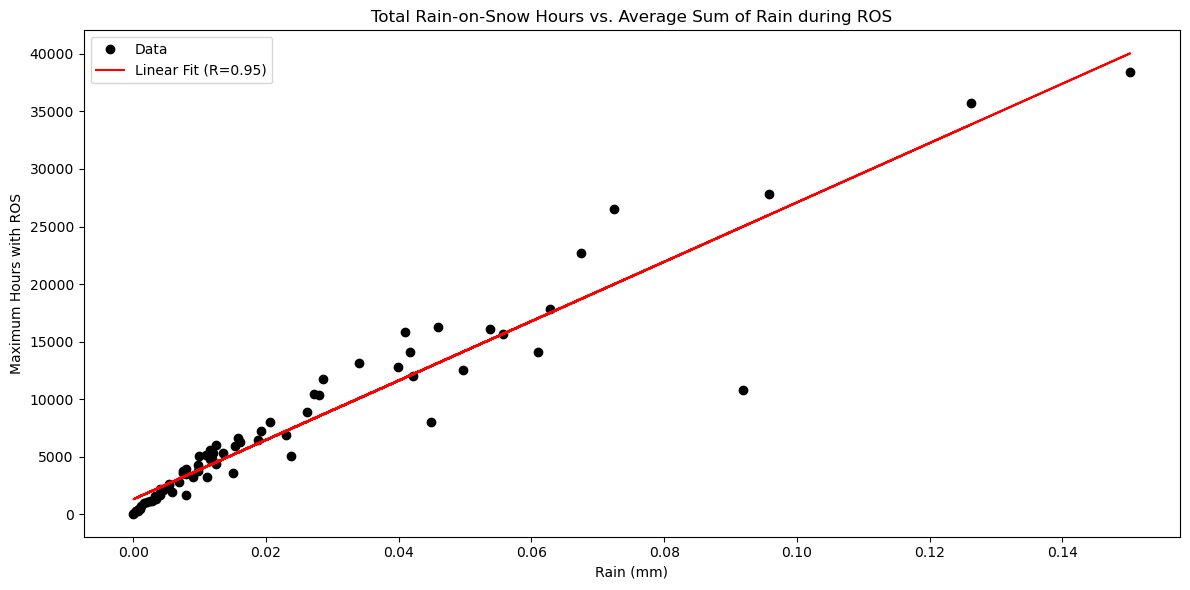

In [17]:
slope, intercept, r_value, p_value, std_err = linregress(rain_sum_ROS_fnsb, ros_hourly_totals_climatology)
x = np.array(rain_sum_ROS_fnsb)
y_fit = slope * x + intercept

plt.figure(figsize=(12, 6))
plt.plot(rain_sum_ROS_fnsb, ros_hourly_totals_climatology, marker='o', linestyle='', color='black', label='Data')
plt.plot(x, y_fit, color='red', label=f'Linear Fit (R={r_value:.2f})')

plt.title('Total Rain-on-Snow Hours vs. Average Sum of Rain during ROS')
plt.xlabel('Rain (mm)')
plt.ylabel('Maximum Hours with ROS')
plt.legend()

plt.tight_layout()
plt.gcf().patch.set_alpha(0.0)
plt.show()

In [18]:
daily_max_values = []
for season in seasons:
    season_data = data.where(data['season'] == season, drop=True)
    
    if season_data['ros_days_count'].size == 0:
        daily_max_values.append(None)  
        continue
    max_val = season_data['ros_days_count'].max().compute().item()
    daily_max_values.append(max_val)

Exploring the dsitributions NEED TO BE CHANGED FOR PRECIP!

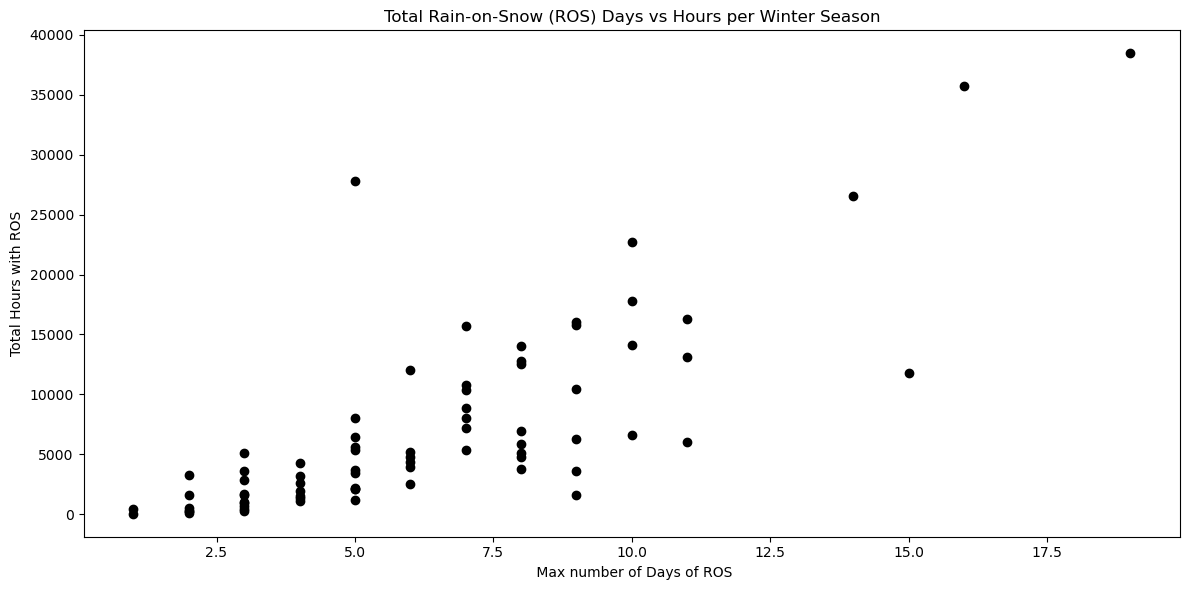

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(daily_max_values, ros_hourly_totals_climatology, marker='o', linestyle='', color='black')
plt.title('Total Rain-on-Snow (ROS) Days vs Hours per Winter Season')
plt.xlabel(' Max number of Days of ROS')
plt.ylabel('Total Hours with ROS')
plt.tight_layout()
fig.patch.set_alpha(0.0)
plt.show()

Average precipiation 
-

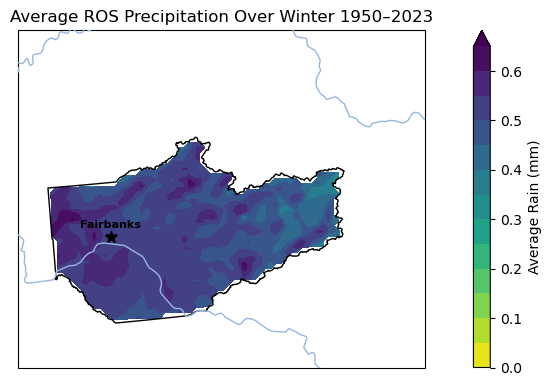

In [32]:
ros_avg_rain = np.mean(data['rain_ros_avg'],axis=0)
AK_ALBERS_SUBPLOT_KW = {
    'projection': ccrs.AlbersEqualArea(central_longitude=-154, central_latitude=50,standard_parallels=(55, 65))}
levels = np.arange(0, 0.66, 0.05) 
cmap = plt.get_cmap('viridis_r')
fig, ax = plt.subplots(subplot_kw=AK_ALBERS_SUBPLOT_KW, figsize=(10, 4))
cf = ax.contourf(lon, lat, ros_avg_rain, levels=levels, cmap=cmap, extend='max',transform=ccrs.PlateCarree())
cbar = fig.colorbar(cf, ax=ax, label='Average Rain (mm)')
cbar.set_ticks(levels[::2])
cbar.ax.set_position([0.77, 0.1, 0.02, 0.8])

FNSB_boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, zorder=2, transform=ccrs.PlateCarree())
ax.scatter(Fairbanks_lon, Fairbanks_lat, marker='*', color='k', zorder=5, s=75,label='Fairbanks', transform=ccrs.PlateCarree())
ax.text(Fairbanks_lon, Fairbanks_lat + 0.05, 'Fairbanks',
        transform=ccrs.PlateCarree(), ha='center', va='bottom',
        fontsize=8, zorder=6, fontweight='bold', color='black')
ax.add_feature(cfeature.BORDERS, zorder=9)
ax.add_feature(cfeature.COASTLINE, zorder=9)
ax.add_feature(cfeature.RIVERS, zorder=9)

ax.set_extent([-149, -143, 64, 66], crs=ccrs.PlateCarree())
ax.set_aspect('equal')
ax.set_title("Average ROS Precipitation Over Winter 1950–2023")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

fig.patch.set_alpha(0.0)
plt.tight_layout()
plt.show() 

Compare the last 30 and first 30 years
-

Last 30 years of data...
-

In [33]:
ros_rain_30_data = data['rain_ros_avg']
last_10_years = 30
seasons_last_10 = seasons[-last_10_years:]  
ros_trend_last_10 = ros_rain_30_data[-last_10_years:, :, :] 
ros_trend_last_30= np.mean(ros_trend_last_10,axis=0)

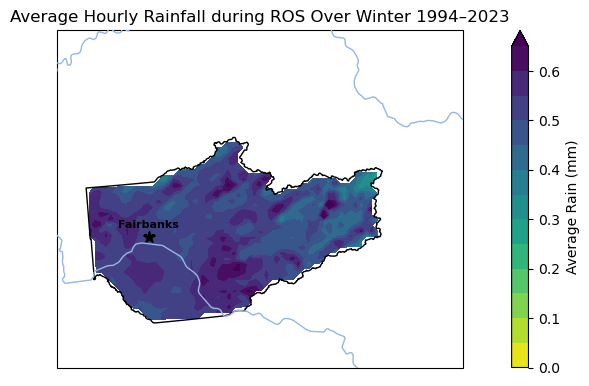

In [34]:
AK_ALBERS_SUBPLOT_KW = {
    'projection': ccrs.AlbersEqualArea(central_longitude=-154, central_latitude=50,standard_parallels=(55, 65))}
levels = np.arange(0, 0.66, 0.05) 
cmap = plt.get_cmap('viridis_r')
fig, ax = plt.subplots(subplot_kw=AK_ALBERS_SUBPLOT_KW, figsize=(10, 4))
cf = ax.contourf(lon, lat, ros_trend_last_30, levels=levels, cmap=cmap, extend='max',transform=ccrs.PlateCarree())
cbar = fig.colorbar(cf, ax=ax, label='Average Rain (mm)')
cbar.set_ticks(levels[::2])
cbar.ax.set_position([0.77, 0.1, 0.02, 0.8])

FNSB_boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, zorder=2, transform=ccrs.PlateCarree())
ax.scatter(Fairbanks_lon, Fairbanks_lat, marker='*', color='k', zorder=5, s=75,label='Fairbanks', transform=ccrs.PlateCarree())
ax.text(Fairbanks_lon, Fairbanks_lat + 0.05, 'Fairbanks',
        transform=ccrs.PlateCarree(), ha='center', va='bottom',
        fontsize=8, zorder=6, fontweight='bold', color='black')
ax.add_feature(cfeature.BORDERS, zorder=9)
ax.add_feature(cfeature.COASTLINE, zorder=9)
ax.add_feature(cfeature.RIVERS, zorder=9)

ax.set_extent([-149, -143, 64, 66], crs=ccrs.PlateCarree())
ax.set_aspect('equal')
ax.set_title("Average Hourly Rainfall during ROS Over Winter 1994–2023")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

fig.patch.set_alpha(0.0)
plt.tight_layout()
plt.show() 

First 30 years of data
-

In [23]:
ros_rain_30_data = data['rain_ros_avg']
last_10_years = 30
seasons_first_10 = seasons[last_10_years:]  
ros_trend_first_10 = ros_rain_30_data[last_10_years:, :, :] 
ros_trend_first_30= np.mean(ros_trend_first_10,axis=0)

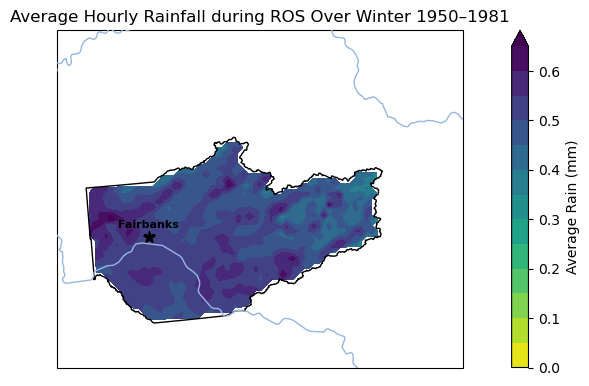

In [35]:
AK_ALBERS_SUBPLOT_KW = {
    'projection': ccrs.AlbersEqualArea(central_longitude=-154, central_latitude=50,standard_parallels=(55, 65))}
levels = np.arange(0, 0.66, 0.05) 
cmap = plt.get_cmap('viridis_r')
fig, ax = plt.subplots(subplot_kw=AK_ALBERS_SUBPLOT_KW, figsize=(10, 4))
cf = ax.contourf(lon, lat, ros_trend_first_30, levels=levels, cmap=cmap, extend='max',transform=ccrs.PlateCarree())
cbar = fig.colorbar(cf, ax=ax, label='Average Rain (mm)')
cbar.set_ticks(levels[::2])
cbar.ax.set_position([0.77, 0.1, 0.02, 0.8])

FNSB_boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, zorder=2, transform=ccrs.PlateCarree())
ax.scatter(Fairbanks_lon, Fairbanks_lat, marker='*', color='k', zorder=5, s=75,label='Fairbanks', transform=ccrs.PlateCarree())
ax.text(Fairbanks_lon, Fairbanks_lat + 0.05, 'Fairbanks',
        transform=ccrs.PlateCarree(), ha='center', va='bottom',
        fontsize=8, zorder=6, fontweight='bold', color='black')
ax.add_feature(cfeature.BORDERS, zorder=9)
ax.add_feature(cfeature.COASTLINE, zorder=9)
ax.add_feature(cfeature.RIVERS, zorder=9)

ax.set_extent([-149, -143, 64, 66], crs=ccrs.PlateCarree())
ax.set_aspect('equal')
ax.set_title("Average Hourly Rainfall during ROS Over Winter 1950–1981")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

fig.patch.set_alpha(0.0)
plt.tight_layout()
plt.show() 

difference 

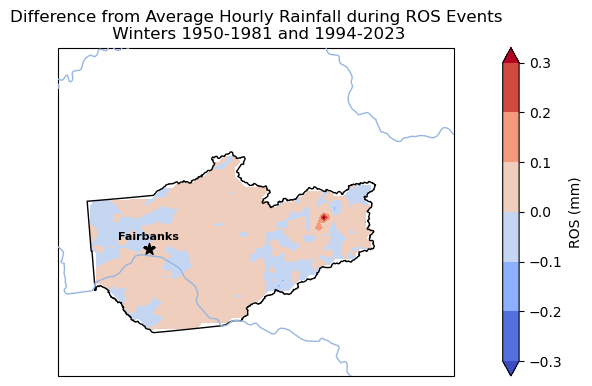

In [36]:
diff= ros_trend_last_30-ros_trend_first_30

AK_ALBERS_SUBPLOT_KW = {
    'projection': ccrs.AlbersEqualArea(central_longitude=-154, central_latitude=50, standard_parallels=(55, 65))}
levels = np.arange(-.3, 0.4,0.1)
cmap = plt.get_cmap('coolwarm')
fig, ax = plt.subplots(subplot_kw=AK_ALBERS_SUBPLOT_KW, figsize=(10, 4))
cf = ax.contourf(lon, lat, diff, levels=levels, cmap=cmap, extend='both', transform=ccrs.PlateCarree())
cbar = fig.colorbar(cf, ax=ax, label='ROS (mm)')
cbar.set_ticks(levels)
cbar.ax.set_position([0.77, 0.1, 0.02, 0.8])

FNSB_boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, zorder=2, transform=ccrs.PlateCarree())
ax.scatter(Fairbanks_lon, Fairbanks_lat, marker='*', color='k', zorder=5, s=75, label='Fairbanks', transform=ccrs.PlateCarree())
ax.text(Fairbanks_lon, Fairbanks_lat + 0.05, 'Fairbanks',
        transform=ccrs.PlateCarree(), ha='center', va='bottom',
        fontsize=8, zorder=6, fontweight='bold', color='black')
ax.add_feature(cfeature.BORDERS, zorder=9)
ax.add_feature(cfeature.COASTLINE, zorder=9)
ax.add_feature(cfeature.RIVERS, zorder=9)

ax.set_extent([-149, -143, 64, 66], crs=ccrs.PlateCarree())
ax.set_aspect('equal')
ax.set_title("Difference from Average Hourly Rainfall during ROS Events\n Winters 1950-1981 and 1994-2023")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
fig.patch.set_alpha(0.0)
plt.tight_layout()
plt.show()

In [38]:
rain_ros_avg_hourly

<xarray.DataArray 'rain_ros_avg' (season: 74, south_north: 450, west_east: 420)> Size: 56MB
dask.array<getitem, shape=(74, 450, 420), dtype=float32, chunksize=(1, 450, 420), chunktype=numpy.ndarray>
Coordinates:
  * season   (season) <U9 3kB '1950-1951' '1951-1952' ... '2023-2024'
    XLAT     (south_north, west_east) float32 756kB dask.array<chunksize=(450, 420), meta=np.ndarray>
    XLONG    (south_north, west_east) float32 756kB dask.array<chunksize=(450, 420), meta=np.ndarray>
Dimensions without coordinates: south_north, west_east

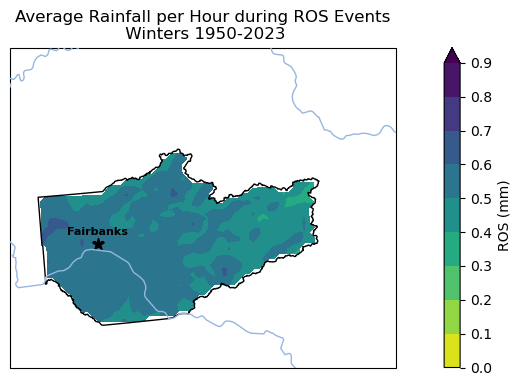

In [40]:
AK_ALBERS_SUBPLOT_KW = {
    'projection': ccrs.AlbersEqualArea(central_longitude=-154, central_latitude=50, standard_parallels=(55, 65))}
levels = np.arange(0, 1,0.1)
cmap = plt.get_cmap('viridis_r')
fig, ax = plt.subplots(subplot_kw=AK_ALBERS_SUBPLOT_KW, figsize=(10, 4))
cf = ax.contourf(lon, lat, np.mean(rain_ros_avg_hourly,axis=0), levels=levels, cmap=cmap, extend='max', transform=ccrs.PlateCarree())
cbar = fig.colorbar(cf, ax=ax, label='ROS (mm)')
cbar.set_ticks(levels)
cbar.ax.set_position([0.77, 0.1, 0.02, 0.8])

FNSB_boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, zorder=2, transform=ccrs.PlateCarree())
ax.scatter(Fairbanks_lon, Fairbanks_lat, marker='*', color='k', zorder=5, s=75, label='Fairbanks', transform=ccrs.PlateCarree())
ax.text(Fairbanks_lon, Fairbanks_lat + 0.05, 'Fairbanks',
        transform=ccrs.PlateCarree(), ha='center', va='bottom',
        fontsize=8, zorder=6, fontweight='bold', color='black')
ax.add_feature(cfeature.BORDERS, zorder=9)
ax.add_feature(cfeature.COASTLINE, zorder=9)
ax.add_feature(cfeature.RIVERS, zorder=9)

ax.set_extent([-149, -143, 64, 66], crs=ccrs.PlateCarree())
ax.set_aspect('equal')
ax.set_title("Average Rainfall per Hour during ROS Events\n Winters 1950-2023")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
fig.patch.set_alpha(0.0)
plt.tight_layout()
plt.show()

In [41]:
averagesumofrain=data['rain_sum']
averagesumofrainros=data['rain_ros_sum']

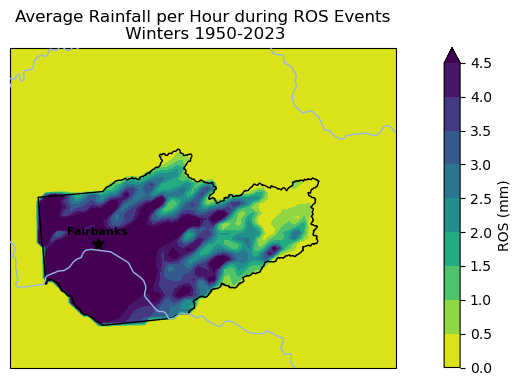

In [44]:
AK_ALBERS_SUBPLOT_KW = {
    'projection': ccrs.AlbersEqualArea(central_longitude=-154, central_latitude=50, standard_parallels=(55, 65))}
levels = np.arange(0, 5.5
                   ,0.5)
cmap = plt.get_cmap('viridis_r')
fig, ax = plt.subplots(subplot_kw=AK_ALBERS_SUBPLOT_KW, figsize=(10, 4))
cf = ax.contourf(lon, lat, np.mean(averagesumofrainros,axis=0), levels=levels, cmap=cmap, extend='max', transform=ccrs.PlateCarree())
cbar = fig.colorbar(cf, ax=ax, label='ROS (mm)')
cbar.set_ticks(levels)
cbar.ax.set_position([0.77, 0.1, 0.02, 0.8])

FNSB_boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, zorder=2, transform=ccrs.PlateCarree())
ax.scatter(Fairbanks_lon, Fairbanks_lat, marker='*', color='k', zorder=5, s=75, label='Fairbanks', transform=ccrs.PlateCarree())
ax.text(Fairbanks_lon, Fairbanks_lat + 0.05, 'Fairbanks',
        transform=ccrs.PlateCarree(), ha='center', va='bottom',
        fontsize=8, zorder=6, fontweight='bold', color='black')
ax.add_feature(cfeature.BORDERS, zorder=9)
ax.add_feature(cfeature.COASTLINE, zorder=9)
ax.add_feature(cfeature.RIVERS, zorder=9)

ax.set_extent([-149, -143, 64, 66], crs=ccrs.PlateCarree())
ax.set_aspect('equal')
ax.set_title("Average Rainfall per Hour during ROS Events\n Winters 1950-2023")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
fig.patch.set_alpha(0.0)
plt.tight_layout()
plt.show()